<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Use TensorFlow to predict handwritten digits</b></font></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook demonstrates how to train and score a Deep Learning model in the Watson Machine Learning (WML) repository.

This notebook contains code for the following items: 

- Obtain data.
- Persist training definitions in the Watson Machine Learning repository.
- Train a Deep Learning model.
- Deploy a trained model.
- Score the trained model.

Some familiarity with Python is helpful. This notebook is compatible with Python 3.5 and uses <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html" target="_blank" rel="noopener no referrer">Watson Studio environments.</a>


## Learning goals

In this notebook, you will learn how to:

-  Set up Watson Machine Learning experiments to train Deep Learning (Tensorflow) models.
-  Save trained models in the Watson Machine Learning repository.
-  Deploy a trained model online and score it.


## Contents

1.	[Set up the environment](#setup)
2.	[Explore data](#data)
3.  [Create training definitions](#model)
4.  [Train a model](#train)
5.	[Save the model](#save)
6.	[Create an online deployment](#deploy)
7.	[Score data](#score)
8.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage can be found <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**
- Create new credentials with HMAC: 
    - Go to your COS dashboard.
    - In the **Service credentials** tab, click **New Credential (+)**.
    - Add the inline configuration parameter: {"HMAC":true}, click **Add**. (For more information, see <a href="https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials" target="_blank" rel="noopener no referrer">HMAC</a>.)

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "-------",
            "secret_access_key": "-------"
       }
    ```

In this section, you learn how to:

- [1.1 Set up the Cloud Object Storage (COS) service](#cos)
- [1.2 Download MNIST data files and upload them to the COS buckets](#mnist)
- [1.3 Set up the Watson Machine Learning (WML) instance](#wml)

### 1.1 Set up the Cloud Object Storage (COS) service <a id="cos"></a>

Install the IBM boto package. This package allows Python developers to manage Cloud Object Storage (COS).

**Tip:** If `ibm_boto3` is not preinstalled in your environment, run the following command to install it: 

In [ ]:
# Run the command if ibm_boto3 is not installed.
!pip install --upgrade ibm-cos-sdk

In [2]:
# Import the boto module.
import ibm_boto3
from ibm_botocore.client import Config

Enter your COS credentials in the following cell. 

You can find these credentials in your COS instance dashboard under the **Service credentials** tab.

**Note:** The HMAC key described in [set up the environment](#setup) is included in these credentials.

In [3]:
cos_credentials = {
    'apikey': '***',
    'cos_hmac_keys': {
        'access_key_id': '***',
        'secret_access_key': '***'
    },
    'endpoints': 'https://cos-service.bluemix.net/endpoints',
    'iam_apikey_description': 'Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/07a95aa44e6124e8b320b70cf88033fa:876e5285-4bef-4cf3-a89b-595e19648c7c::',
    'iam_apikey_name': 'auto-generated-apikey-19a79dae-6a58-4b4f-878f-6839b711523f',
    'iam_role_crn': 'crn:v1:bluemix:public:iam::::serviceRole:Writer',
    'iam_serviceid_crn': 'crn:v1:bluemix:public:iam-identity::a/07a95aa44e6124e8b320b70cf88033fa::serviceid:ServiceId-3f2cccee-61ec-4147-8732-9f58479ba26a',
    'resource_instance_id': 'crn:v1:bluemix:public:cloud-object-storage:global:a/07a95aa44e6124e8b320b70cf88033fa:876e5285-4bef-4cf3-a89b-595e19648c7c::'
}

Define the endpoint.

To do this, go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information, then copy-and-paste it in the cell below:

In [5]:
# Define endpoint information.
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

You also need the IBM Cloud authorization endpoint to be able to create COS resource object.

In [6]:
# Define the authorization endpoint.
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

Create a Boto resource to be able to write data to COS.

In [7]:
# Create a COS resource.
cos = ibm_boto3.resource(
    's3',
     ibm_api_key_id=cos_credentials['apikey'],
     ibm_service_instance_id=cos_credentials['resource_instance_id'],
     ibm_auth_endpoint=auth_endpoint,
     config=Config(signature_version='oauth'),
     endpoint_url=service_endpoint
)

Create two buckets, which you will use to store training data and training results.

**Note:** The bucket names must be unique.

In [8]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "training-data-ce6d44c1-19d5-47ed-aca7-6b45a62150c8"...
Creating bucket "training-results-ce6d44c1-19d5-47ed-aca7-6b45a62150c8"...


Now, you should have 2 buckets.

In [9]:
# Display a list of created buckets.
print(list(cos.buckets.all()))

[s3.Bucket(name='9fff2508-60c5-4e75-835b-210aa00ff010-style-data'), s3.Bucket(name='9fff2508-60c5-4e75-835b-210aa00ff010-style-results'), s3.Bucket(name='aiopenscalepythonclient-donotdelete-pr-hp7rm9ptqfgzw7'), s3.Bucket(name='aiopenscaletutorial-donotdelete-pr-uwusxqgchfwz2j'), s3.Bucket(name='aispheredemo-donotdelete-pr-s7lhzejm05qqne'), s3.Bucket(name='aispherescenario-datacatalog-sydghgvlq'), s3.Bucket(name='ale-kupa-in'), s3.Bucket(name='aparbuganalysis-donotdelete-pr-u8wdjkxlhda3sz'), s3.Bucket(name='batch-job-3c4e33a1-e7e5-4ef8-acd3-9f873d7d3d3f'), s3.Bucket(name='cars4you-train-data'), s3.Bucket(name='cifar-keras-nnm-input'), s3.Bucket(name='coreml-donotdelete-pr-5lprxel1c6jrfp'), s3.Bucket(name='coreml-mnist-input-data'), s3.Bucket(name='creditcardfraud545b518d4ec34681aa7e8e8680b486d5'), s3.Bucket(name='datasphereworkshops-donotdelete-pr-xfdm0p7mjo5ms6'), s3.Bucket(name='externalenginesopenscale-donotdelete-pr-osaesm54pzkuww'), s3.Bucket(name='lab4openscale-donotdelete-pr-sil3

### 1.2 Download the MNIST training data files and upload them to the COS buckets <a id="mnist"></a>

Download the training data and upload it to the 'training-data' bucket.
First, create a list of links for the training data set.

**Tip**: The MNIST data sets that you are downloading from the links in the following cell are basically the same ones in the ``python-mnist`` package.

In [10]:
# Create a list of links.
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', # Training set images
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', # Training set labels
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',  # Test set images
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']  # Test set labels

The code in the next cell uploads files from links to your COS.

In [11]:
# Upload files from the links to COS
from urllib.request import urlopen

bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.
Uploading data train-labels-idx1-ubyte.gz...
train-labels-idx1-ubyte.gz is uploaded.
Uploading data t10k-images-idx3-ubyte.gz...
t10k-images-idx3-ubyte.gz is uploaded.
Uploading data t10k-labels-idx1-ubyte.gz...
t10k-labels-idx1-ubyte.gz is uploaded.


Have a look at the list of the created buckets and each bucket's content.

In [12]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print('  File: {}, {:4.2f}kB'.format(obj.key, obj.size/1024))

training-data-ce6d44c1-19d5-47ed-aca7-6b45a62150c8
  File: t10k-images-idx3-ubyte.gz, 1610.23kB
  File: t10k-labels-idx1-ubyte.gz, 4.44kB
  File: train-images-idx3-ubyte.gz, 9680.10kB
  File: train-labels-idx1-ubyte.gz, 28.20kB
training-results-ce6d44c1-19d5-47ed-aca7-6b45a62150c8


You are done with COS and ready to train your model!

### 1.3 Set up the Watson Machine Learning (WML) instance <a id="wml"></a>

Import the modules you need to set up your WML instance.

**Hint:** You may also need to install `wget` using the following command: `!pip install --upgrade wget`

In [ ]:
!pip install --upgrade wget

In [14]:
import urllib3
import json
import os
import wget

Authenticate the Watson Machine Learning (WML) service on the IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://console.bluemix.net/docs/services/service_credentials.html#service_credentials" target="_blank" rel="noopener noreferrer">Service credentials</a> tab of the service instance that you created on the IBM Cloud. 
If there are no credentials listed for your instance in **Service credentials**, click **New credential (+)** and enter the information required to generate new authentication information. 

**Action**: Enter your WML service instance credentials in the following cell.

In [15]:
wml_credentials = {
    'username': '***',
    'password': '***',
    'instance_id': '***',
    'url': 'https://ibm-watson-ml.mybluemix.net'
}

#### Install the `watson-machine-learning-client` package from pypi.

**Note:** `watson-machine-learning-client` documentation can be found <a href="http://wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener noreferrer">here</a>.

In [17]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [ ]:
!pip install --upgrade watson-machine-learning-client

#### Import the `watson-machine-learning-client` and authenticate the service instance.

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

**Note:** You might see deprecation warning(s) from scikit-learn package that does (do) not impact watson machine learning client functionality.

In [20]:
client = WatsonMachineLearningAPIClient(wml_credentials)

<a id="data"></a>
## 2. Explore data

In this section, you will check how the input data look like. You need `python-mnist` and `matplotlib` packages to see how each data point looks like.

First, download all image data sets and label files.

In [21]:
for d in data_links:
    wget.download(d)

Check if the all files are successfully downloaded to the local file system by running **ls** (shell command).

In [22]:
!ls

2dcc72ce-16c2-4ad0-94c8-77f37317b47b  t10k-labels-idx1-ubyte.gz
f7982685-3040-4936-a7a4-d42aec6b2e1c  train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz	      train-labels-idx1-ubyte.gz


Decompress all downloaded files.

In [23]:
!gzip -df *.gz

According to section [1.2 Download the training data and upload it to the COS buckets](#mnist), the downloaded files above can be found in ``python-mnist`` package.

Install python-mnist package in order to view each image in the data sets.

In [ ]:
!pip install --upgrade python-mnist

Import MNIST module from mnist package and load the training data set.

In [25]:
from mnist import MNIST

mndata = MNIST('')
train_images, train_labels = mndata.load_training()

Import `matplotlib` and `numpy` to see how handwritten digits look like.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

A function that displays images and labels.

In [27]:
def display_digits(images, labels, length, title):
    images_and_labels = list(zip(images, labels))
    for index, (image, label) in enumerate(images_and_labels[:length]):
        plt.subplot(length, length, index + 1)
        plt.axis('off')
        plt.imshow((np.reshape(np.array(image)/255, (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(title + ': %i' % label)
        plt.tight_layout()

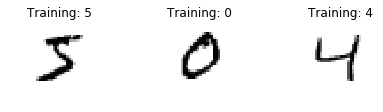

In [28]:
display_digits(train_images, train_labels, 3, 'Training')

<a id="model"></a>
## 3. Create the training definitions

In this section you:

- [3.1 Create the training definition metadata](#prep)
- [3.2 Get the sample model definition content files from Git](#get)
- [3.3 Store the training definitions in the WML repository](#store)



### 3.1 Create the training definition metadata<a id="prep"></a>

In [29]:
model_definition_metadata = {
    client.repository.DefinitionMetaNames.NAME: 'My definition name',
    client.repository.DefinitionMetaNames.DESCRIPTION: 'My description',
    client.repository.DefinitionMetaNames.AUTHOR_NAME: 'John Smith',
    client.repository.DefinitionMetaNames.FRAMEWORK_NAME: 'tensorflow',
    client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: '1.5',
    client.repository.DefinitionMetaNames.RUNTIME_NAME: 'python',
    client.repository.DefinitionMetaNames.RUNTIME_VERSION: '3.5',
    client.repository.DefinitionMetaNames.EXECUTION_COMMAND: 'python3 tensorflow_mnist_softmax.py --trainingIters 20'
}

### 3.2 Get the sample model definition content file from Git <a id="get"></a>

In [30]:
filename='tf-softmax-model.zip'

if not os.path.isfile(filename):
    filename = wget.download('https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip')
    
print(filename)

tf-softmax-model.zip


### 3.3 Store the training definition in the WML repository<a id="store"></a>

In [31]:
definition_details = client.repository.store_definition(filename, model_definition_metadata)

In [32]:
definition_uid = client.repository.get_definition_uid(definition_details)

In [33]:
# Display the training definition uid.
print(definition_uid)

607e8219-48ca-4546-9e5f-482c4c502433


## 4. Train a model<a id="train"></a>

In this section, you will learn how to:
- [4.1 Configure training metadata](#meta)
- [4.2 Train the model in the background](#backg)
- [4.3 Monitor the training log](#log)
- [4.4 Cancel the training run](#cancel)


### 4.1 Configure training metadata<a id="meta"></a>

- `TRAINING_DATA_REFERENCE` - references the uploaded training data.
- `TRAINING_RESULTS_REFERENCE` - location where the trained model will be saved.

**Note**: Your COS credentials are referenced in this code.


In [34]:
# Configure the training metadata for the TRAINING_DATA_REFERENCE and TRAINING_RESULTS_REFERENCE.
training_configuration_metadata = {
    client.training.ConfigurationMetaNames.NAME: 'Hand-written Digit Recognition', 
    client.training.ConfigurationMetaNames.AUTHOR_NAME: 'John Smith',              
    client.training.ConfigurationMetaNames.DESCRIPTION: 'Hand-written Digit Recognition training',
    client.training.ConfigurationMetaNames.COMPUTE_CONFIGURATION: {'name': 'k80'},
    client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
        'connection': {
            'endpoint_url': service_endpoint,
            'access_key_id': cos_credentials['cos_hmac_keys']['access_key_id'],
            'secret_access_key': cos_credentials['cos_hmac_keys']['secret_access_key']
        },
        'source': {
            'bucket': buckets[0]
        },
        'type': 's3'
    },
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
        'connection': {
            'endpoint_url': service_endpoint,
            'access_key_id': cos_credentials['cos_hmac_keys']['access_key_id'],
            'secret_access_key': cos_credentials['cos_hmac_keys']['secret_access_key']
        },
        'target': {
            'bucket': buckets[1]
        },
        'type': 's3'
    }
}

### 4.2 Train the model in the background<a id="backg"></a>

To run the training in the **background**, please set the optional parameter `asynchronous` as `True` (or remove it). In this case, the parameter has been removed. 

**Note:** To run the training in **active** mode, please set the optional parameter `asynchronous` as `False`.

In [35]:
training_run_details = client.training.run(definition_uid, training_configuration_metadata)

In [36]:
training_run_guid_async = client.training.get_run_uid(training_run_details)

Check the status of the training run by calling the method the next cell:

In [37]:
# Get training run status.
status = client.training.get_status(training_run_guid_async)
print(json.dumps(status, indent=2))

{
  "metrics": [],
  "state": "pending",
  "message": "training-g73NScjmg: Submitted",
  "current_at": "2019-03-06T12:17:58.808Z",
  "submitted_at": "2019-03-06T12:17:55.581Z"
}


### 4.3  Monitor the training log<a id="log"></a>

Run the cell below to monitor the training log.

In [38]:
client.training.monitor_logs(training_run_guid_async)



####################################################

Log monitor started for training run: model-n4zbjfqo

####################################################


training-g73NScjmg: 
training-g73NScjmg: 
training-g73NScjmg: 
training-g73NScjmg: 
training-g73NScjmg: 
training-g73NScjmg: 
training-g73NScjmg: 
training-g73NScjmg: Training with training/test data at:

training-g73NScjmg:   DATA_DIR: /mnt/data/training-data-ce6d44c1-19d5-47ed-aca7-6b45a62150c8

training-g73NScjmg:   MODEL_DIR: /job/model-code

training-g73NScjmg:   TRAINING_JOB: 

training-g73NScjmg:   TRAINING_COMMAND: python3 tensorflow_mnist_softmax.py --trainingIters 20

training-g73NScjmg: Storing trained model at:

training-g73NScjmg:   RESULT_DIR: /mnt/results/training-results-ce6d44c1-19d5-47ed-aca7-6b45a62150c8/training-g73NScjmg

training-g73NScjmg: Wed Mar  6 12:50:03 UTC 2019: Running Tensorflow job

training-g73NScjmg: 
training-g73NScjmg: 
training-g73NScjmg: /usr/local/lib/python3.5/dist-packages/h5py/__in

### 4.4 Cancel the training run<a id="cancel"></a>

You can cancel the training run by calling the method below.

<a id="save"></a>
## 5. Save the model

#### Call this method to the save the trained model in the WML repository.

In [39]:
# Save model to WML repository.
saved_model_details = client.repository.store_model(training_run_guid_async, {"name": "My cool mnist model"})

In [40]:
# Display location of saved model.
print('Url: ' + client.repository.get_model_url(saved_model_details))

Url: https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/193f97a4-2a48-4be7-9497-11ccc58aebb3


**Tip:** Run the code below to extract the stored model uid from the dictionary.

In [41]:
# Get and display model uid.
model_uid = client.repository.get_model_uid(saved_model_details)
print('Saved model uid: ' + model_uid)

Saved model uid: 193f97a4-2a48-4be7-9497-11ccc58aebb3


#### List the stored models.

In [42]:
client.repository.list_models()

------------------------------------  -------------------------------------------  ------------------------  -----------------
GUID                                  NAME                                         CREATED                   FRAMEWORK
193f97a4-2a48-4be7-9497-11ccc58aebb3  My cool mnist model                          2019-03-06T12:52:11.179Z  tensorflow-1.5
2dcc72ce-16c2-4ad0-94c8-77f37317b47b  Boston house price prediction                2019-03-06T11:45:30.725Z  scikit-learn-0.19
f7982685-3040-4936-a7a4-d42aec6b2e1c  Boston house price prediction                2019-03-06T11:32:56.268Z  scikit-learn-0.19
c9dfebfa-0411-4e3e-a9c5-9a311444ed59  CHAID PMML model for Iris data               2019-03-04T12:59:21.351Z  pmml-4.2
c0e97a79-7db0-471e-afd8-f3e238fd16b6  XGBoost model for breast cancer              2019-02-28T19:11:24.484Z  scikit-learn-0.19
8008b47c-0f07-482c-8d2f-0b6940c824e5  SMS Spam prediction model                    2019-02-28T00:57:59.713Z  scikit-learn-0.19
f2ea

#### Delete the training run and its results.

Run the code in the cell below to delete train runs and results:

## 6. Create an online deployment<a id="deploy"></a>

Run the code in the following cell to deploy the stored model as a web service (online):

In [43]:
client.deployments.list()

------------------------------------  -------------------------------------------------------  -------  --------------  ------------------------  -----------------  -------------
GUID                                  NAME                                                     TYPE     STATE           CREATED                   FRAMEWORK          ARTIFACT TYPE
d250df1b-6e43-4c69-98d2-10ff25b5d63d  Virtual deployment of Boston model                       virtual  DEPLOY_SUCCESS  2019-03-06T11:45:33.176Z  scikit-learn-0.19  model
6d3cf6bb-db92-427c-8b52-9d050d7bfec8  Virtual deployment of Boston model                       virtual  DEPLOY_SUCCESS  2019-03-06T11:32:59.110Z  scikit-learn-0.19  model
ded4770f-c2fe-4653-9ce2-0c79ecfa10be  Iris species prediction                                  online   DEPLOY_SUCCESS  2019-03-04T12:59:23.413Z  pmml-4.2           model
450f555b-1952-4ef1-90be-96a16f600345  Predict breast cancer                                    online   DEPLOY_SUCCESS  2019-02-2

In [44]:
# Create online deployment.
deployment_details = client.deployments.create(model_uid, 'Mnist model deployment')



#######################################################################################

Synchronous deployment creation for uid: '193f97a4-2a48-4be7-9497-11ccc58aebb3' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='86da6500-18ff-4970-b3e4-7e335d4a08f9'
------------------------------------------------------------------------------------------------




## 7. Score data<a id="score"></a>

Now, extract the url endpoint and scoring_url which will be used to send scoring requests.

In [ ]:
#  Extract endpoint url and display it.
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

Prepare sample scoring data to score deployed model. You will use again the `python-mnist` package that we used before.

In [46]:
test_images, test_labels = mndata.load_testing()
test_length = 3

The `display_digits` function introduced in section [2. Explore data](#data) will be used again to display test images.

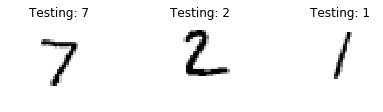

In [47]:
display_digits(test_images, test_labels, test_length, 'Testing')

Build a scoring dictionary consisting of two digits and send it to the deployed model to get predictions.

In [48]:
# Build scoring dictionary which has three digits.
scoring_data = {'values': test_images[:test_length]}

In [49]:
# Send scoring dictionary to deployed model to get predictions.
predictions = client.deployments.score(scoring_url, scoring_data)
print('Scoring result: ' + str(predictions))

Scoring result: {'values': [7, 2, 1]}


<a id="summary"></a>
## 8. Summary and next steps     

You successfully completed this notebook! 
 
You learned how to use the Watson Machine Learning API client (`watson-machine-learning-client`) to train and score a TensorFlow model. 
 
Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for a <a href="https://dataplatform.ibm.com/docs/content/analyze-data/ml-python-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">tutorial</a> and more samples, documentation, how-tos, and blog posts. 

### Citation
Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.

### Authors

**Lukasz Cmielowski**, Ph.D., is a Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increase the clients' ability to turn data into actionable knowledge.  
**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who strives to make data science easy for everyone through Watson Studio.

Copyright © 2017-2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>